In [1]:
from glob import glob

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io import wavfile
from scipy.stats import zscore

from util.path import Path
from encoding import build_regressors
from util import subject

from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap

from constants import RUNS, NRUNS, TR, BLU, ORG

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


In [3]:
sub = 5
run = None
trial = None
item = None
first = None
conv = subject.get_conv(sub)

In [4]:
eventpath = Path(
    root="stimuli",
    conv=conv,
    datatype="transcript",
    run=run,
    trial=trial if trial is not None else None,
    item=item,
    condition=None,
    first=first,
    suffix="aligned",
    ext=".csv",
)
eventpath

stimuli/conv-105/transcript/conv-105_aligned.csv

In [5]:
search_str = eventpath.starstr(['conv', 'datatype'])
print(search_str)
files = glob(search_str)
for fn in files:
    print(fn)

stimuli/conv-105/transcript/conv-105*_aligned.csv


In [7]:
eventpath = Path.frompath(files[0].split('/')[-1])
eventpath.update(root='stimuli', datatype='transcript')
eventpath

stimuli/conv-105/transcript/conv-105_run-3_set-2_trial-12_item-12_condition-G_first-B_aligned.csv

# Visualize transcript

In [53]:
df = pd.read_csv(eventpath)
df.ffill(inplace=True)
df

,speaker,sentence,word,start,end,score
0,4,1,Um...,2.341,2.482,0.746
1,4,1,can,4.108,4.229,0.523
2,4,1,you,4.249,4.369,0.778
3,4,1,summarize,4.390,4.751,0.528
4,4,1,the,4.791,4.871,0.953
...,...,...,...,...,...,...
490,4,2,it,176.524,176.597,0.252
491,4,2,definitely,176.645,177.224,0.413
492,4,2,plays,177.297,177.562,0.735
493,4,2,a,177.659,177.900,0.576


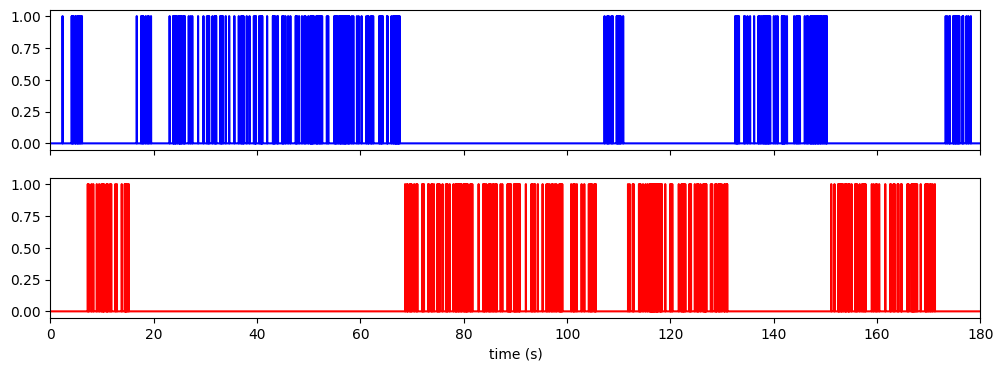

In [56]:
xaxis = np.arange(180 * 1000) / 1000

upto = int(df.start.max() * 1000) + 1
subA = np.zeros(180000)
subA[(df[df.speaker == sub].start * 1000).astype(int)] = 1

subB = np.zeros_like(subA)
subB[(df[df.speaker != sub].start * 1000).astype(int)] = 1

fig, axes = plt.subplots(2, 1, figsize=(12, 4), sharex=True)
axes[0].set_xlim(0, 180)
axes[0].plot(xaxis, subA, color="blue")
axes[1].plot(xaxis, subB, color="red")
axes[1].set_xlabel("time (s)")
fig.show()

# Figure 1

## setup

In [8]:
run = eventpath['run']
trial = ((int(eventpath["trial"]) - 1) % 4) + 1
slices = [slice(i, i+240) for i in range(0, 1200, 240)]
run, trial

(3, 4)

In [10]:
X, features = build_regressors(sub, modelname='model-opt-7b_layer-23')
X.shape, features

((1200, 8405),
 {'task': slice(0, 9, None),
  'spectral': slice(9, 169, None),
  'articulation': slice(169, 213, None),
  'prod_semantic': slice(213, 4309, None),
  'comp_semantic': slice(4309, 8405, None)})

In [11]:
# get just one trial
Xt = X[slices[run-1]][:120]
Xt.shape

(120, 8405)

## 1a

In [23]:
data = subject.get_bold(sub, use_cache=True, cache_desc='trialmot6')
run_data = data[slices[run-1]]
trial_data = run_data[:120] # get first trial always (can fix later)
trial_data.shape

(120, 81924)

In [24]:
dataB = subject.get_bold(subject.get_partner(sub), use_cache=True, cache_desc='trialmot6')
run_dataB = dataB[slices[run-1]]
trial_dataB = run_dataB[:120] # get first trial always (can fix later)
trial_dataB.shape

(120, 81924)

In [24]:
audiopath = eventpath.copy()
audiopath.update(datatype='audio', suffix=None, ext='.wav')
fs, audio_data = wavfile.read(audiopath)
audio_data.shape

(2871296,)

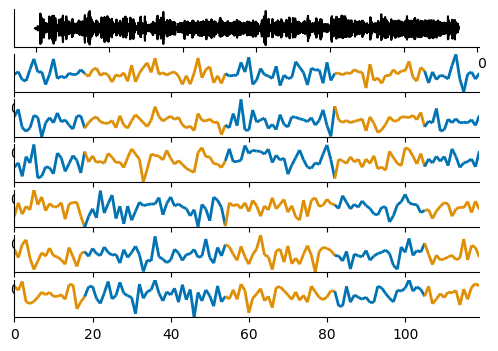

In [34]:
x = np.arange(120)

id_vars = X[slices[run-1], [1, 2]][:120]
bounds = np.diff(id_vars[:, 0]).nonzero()[0]

fig, axes = plt.subplots(7, 1, figsize=(6, 4))
axes[0].plot(zscore(audio_data), c='k')

# plot subA data
for j, i in enumerate(range(2, 5), 1):
    ax = axes[j]
    y = zscore(trial_data[:, i])

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cmap = ListedColormap([BU, OR, BU, OR, BU])
    norm = BoundaryNorm([0] + list(bounds), cmap.N)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(x)
    lc.set_linewidth(2)
    ax.add_collection(lc)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())

# plot subB data
for j, i in enumerate(range(5, 8), 4):
    ax = axes[j]
    y = zscore(trial_dataB[:, i])

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cmap = ListedColormap([OR, BU, OR, BU, OR])
    norm = BoundaryNorm([0] + list(bounds), cmap.N)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(x)
    lc.set_linewidth(2)
    ax.add_collection(lc)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())

for ax in axes:
    ax.set_yticks([])

sns.despine(fig)
    
fig.savefig('figures/fig1a-artifacts.svg')
fig.show()

## 1b

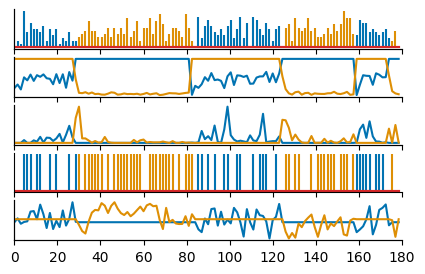

In [33]:
xaxis = np.arange(120) * 1.5
fig, axes = plt.subplots(5, 1, figsize=(5, 3), sharex=True)

# axes[0].step(xaxis, Xt[:, 1], c='k')

# phonemes
ax = axes[0]
ax.stem(xaxis, Xt[:, 3], BU, markerfmt='')
ax = ax.twinx()
ax.stem(xaxis, Xt[:, 7], OR, markerfmt='')
ax.set_yticks([])

# spectral channel
c = 0
axes[1].plot(xaxis, zscore(Xt[:, 9+c]), c=BU)
ax = axes[1].twinx()
ax.plot(xaxis, zscore(Xt[:, 9+80+c]), c=OR)
ax.set_yticks([])

# motion channel
c = 23
axes[2].plot(xaxis, Xt[:, 213+c], c=BU)
ax = axes[2].twinx()
ax.plot(xaxis, Xt[:, 213+25+c], c=OR)
ax.set_yticks([])

# articulation channel
c = 2
axes[3].stem(xaxis, Xt[:, 169+c], BU, markerfmt='')
axes[3].stem(xaxis, Xt[:, 169+22+c], OR, markerfmt='')

# LLM
ax = axes[4]
ax.plot(xaxis, Xt[:, 263], c=BU)
ax = ax.twinx()
ax.plot(xaxis, Xt[:, 263+1024], c=OR)
ax.set_yticks([])

for ax in axes:
    ax.set_yticks([])

sns.despine(fig)

fig.savefig('figures/fig1b-artifacts.svg')
axes[0].set_xlim(0, 180)
fig.show()

## 1c

In [95]:
with h5py.File(f'encoding_motion-enconly/sub-{sub:03d}/model-gpt2-xl_layer-0.75/sub-{sub:03d}.hdf5') as f:
    # get first test fold (last trial?)
    # get first trial from it
    # get one voxel
    preds = f['cv_preds'][2, :, :120, 44828]
    scores = f['cv_scores'][2]
# scores = scores.mean(0)
preds.shape, scores.shape

((6, 120), (6, 81924))

In [91]:
scores.mean(0).argsort()[-10:]

array([ 5950, 57354, 56466, 53650, 48423, 69232, 79226, 49010, 29242,
       50073])

In [93]:
avgscore = (2 * scores[-2] * scores[-1]) / (scores[-2] + scores[-1] + 1e9)
avgscore.argsort()[-5:]

array([57243, 15158, 56519, 10433, 44828])

In [94]:
scores[:, 44828].round(3)

array([ 0.   ,  0.   ,  0.   , -0.025,  0.366,  0.353], dtype=float32)

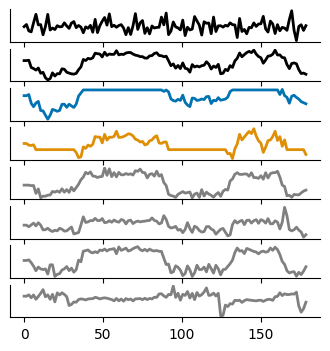

In [102]:
xaxis = np.arange(120) * 1.5
fig, axes = plt.subplots(8, 1, figsize=(4, 4), sharex=True)

# plot actual
ax = axes[0]
ax.plot(xaxis, zscore(trial_data[:, 2]), color='k', lw=2)

# plot joint of all 
ax = axes[1]
ax.plot(xaxis, zscore(preds.sum(0)), c='k', lw=2)

# plot prediction of each
for i, ax in zip([4, 5, 0, 1, 2, 3], axes[2:]):
    color = 'gray'
    if i == 5:
        color = OR
    elif i == 4:
        color = BU
    ax.plot(xaxis, zscore(preds[i]), color=color, lw=2)

for ax in axes:
    ax.set_yticks([])
sns.despine(fig)
fig.savefig('figures/fig1c-artifacts.svg')
fig.show()

## brain

In [6]:
from neuromaps.datasets import fetch_fslr
from surfplot import Plot

surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
p = Plot(lh, rh)

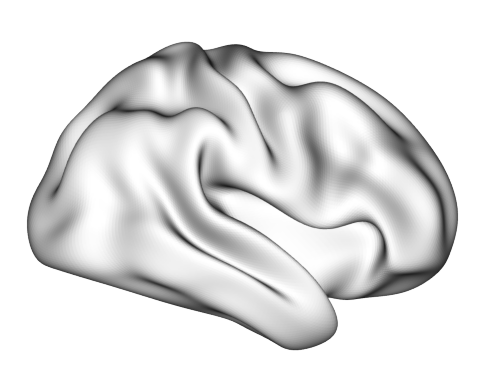

In [33]:
p = Plot(surf_rh=rh, views='lateral', brightness=0.8)
fig = p.build()
# fig.savefig('figures/fig1a-brain.svg')

In [45]:
cmap = sns.color_palette('colorblind').as_hex()
print(cmap[0])
print(cmap[3])
print(cmap[4])
cmap

#0173b2
#d55e00
#cc78bc


['#0173b2',
 '#de8f05',
 '#029e73',
 '#d55e00',
 '#cc78bc',
 '#ca9161',
 '#fbafe4',
 '#949494',
 '#ece133',
 '#56b4e9']

In [18]:
from util.plot import get_surfplot

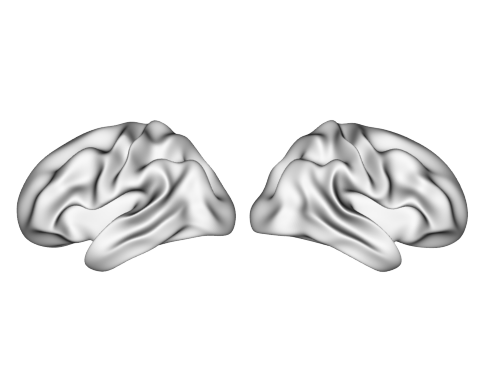

In [26]:
p = get_surfplot(views='lateral', zoom=1.2, inflation=50, sulc_alpha=0, brightness=0.75)
fig = p.build()
fig.show()

# Figure 3

In [13]:
sub, run, trial, slices

(5,
 3,
 4,
 [slice(0, 240, None),
  slice(240, 480, None),
  slice(480, 720, None),
  slice(720, 960, None),
  slice(960, 1200, None)])

In [14]:
subB = subject.get_partner(sub)
subB

105

In [34]:
with h5py.File('encoding/trialmot6/sub-005/model-opt-7b_layer-23/sub-005.hdf5', 'r') as f:
    subA_prod_preds = f['cv_preds'][run-1, -2, :120, 5]
    subA_comp_preds = f['cv_preds'][run-1, -1, :120, 5]
subA_prod_preds.shape

(120,)

In [27]:
with h5py.File('encoding/trialmot6/sub-105/model-opt-7b_layer-23/sub-105.hdf5', 'r') as f:
    subB_preds = f['cv_preds'][run-1, :-2, :120, 5].sum(0)
subB_preds.shape

(120,)

In [29]:
actual_b = trial_dataB[:, 5]
actual_b.shape

(120,)

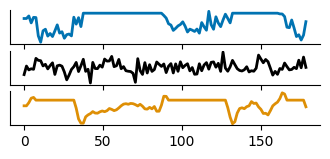

In [43]:
fig, axes = plt.subplots(3, 1, figsize=(4, 1.5), sharex=True)

xaxis = np.arange(120) * 1.5
axes[0].plot(xaxis, zscore(subA_prod_preds), color=BU, lw=2)
axes[1].plot(xaxis, zscore(actual_b - subB_preds), c='k', lw=2)
axes[2].plot(xaxis, zscore(subA_comp_preds), color=OR, lw=2)

for ax in axes:
    ax.set_yticks([])
sns.despine(fig)
fig.savefig('figures/fig3a-artifacts.svg')
fig.show()

# language hierarchy

In [9]:
from nltk.corpus import cmudict
arpabet = cmudict.dict()

In [2]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

In [16]:
doc = nlp("I put the lasagna in.")

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.morph, arpabet.get(token.text.lower(), [None])[0])


I I PRON PRP nsubj Case=Nom|Number=Sing|Person=1|PronType=Prs ['AY1']
put put VERB VBD ROOT Tense=Past|VerbForm=Fin ['P', 'UH1', 'T']
the the DET DT det Definite=Def|PronType=Art ['DH', 'AH0']
lasagna lasagna PROPN NNP dobj Number=Sing ['L', 'AA0', 'S', 'AA1', 'N', 'Y', 'AH0']
in in ADP RP prt  ['IH0', 'N']
. . PUNCT . punct PunctType=Peri None


In [17]:
displacy.render(doc, style='dep')

# Custom atlas ROIS

In [13]:
import sys
from importlib import reload
reload(sys.modules['util.plot'])

from util.atlas import Atlas
from util import plot

fslr_params = dict(surface='fslr', density='32k', transform='fsaverage_to_fslr')

In [3]:
# from LanAtlas paper SI-I fig
rois = {
    'LH_SM': [f'L_{l}_ROI' for l in ['3b', '3a', '4']],
    'LH_EarlyAud': ['L_A1_ROI', 'L_A4_ROI', 'L_LBelt_ROI', 'L_PBelt_ROI', 'L_MBelt_ROI'],
    'LH_AntTemp': [f'L_{l}_ROI' for l in ['TA2', 'STSva', 'STSda', 'STGa', 'Pl', 'A5']],
    'LH_PostTemp': [f'L_{l}_ROI' for l in ['TPOJ1', 'TPOJ2', 'STV', 'STSvp', 'STSdp', 'PSL', 'PHT', 'PGi']],
    'LH_MFG': [f'L_{l}_ROI' for l in ['FEF', '55b']],
    'LH_IFG': [f'L_{l}_ROI' for l in ['IFSp', 'IFJa', '44']],
    'LH_IFGorb': [f'L_{l}_ROI' for l in ['47l', '45']],
    'LH_AngG': [f'L_{l}_ROI' for l in ['TPOJ3', 'PGs']],
    'LH_PMC': [f'L_{l}_ROI' for l in ['31a', '31pd', '31pv']],
    'LH_PreCun': ['L_POS2_ROI'],
}
flip = lambda x: ['R' + r[1:] for r in x]
rois |= {k.replace('LH_', 'RH_') : flip(v) for k, v in rois.items()}
len(rois)

20

In [6]:
atlas = Atlas.glasser2016()
label_img = np.zeros_like(atlas.label_img)
labels = {0: '???'}
for i, (k, v) in enumerate(rois.items(), 1):
    mask = atlas.roimask(v)
    print(i, k, v, mask.sum())
    label_img[mask] = i
    labels[i] = k
custom_atlas = Atlas('custom', label_img, labels)

1 LH_SM ['L_3b_ROI', 'L_3a_ROI', 'L_4_ROI'] 2166
2 LH_EarlyAud ['L_A1_ROI', 'L_A4_ROI', 'L_LBelt_ROI', 'L_PBelt_ROI', 'L_MBelt_ROI'] 818
3 LH_AntTemp ['L_TA2_ROI', 'L_STSva_ROI', 'L_STSda_ROI', 'L_STGa_ROI', 'L_Pl_ROI', 'L_A5_ROI'] 681
4 LH_PostTemp ['L_TPOJ1_ROI', 'L_TPOJ2_ROI', 'L_STV_ROI', 'L_STSvp_ROI', 'L_STSdp_ROI', 'L_PSL_ROI', 'L_PHT_ROI', 'L_PGi_ROI'] 1905
5 LH_MFG ['L_FEF_ROI', 'L_55b_ROI'] 371
6 LH_IFG ['L_IFSp_ROI', 'L_IFJa_ROI', 'L_44_ROI'] 442
7 LH_IFGorb ['L_47l_ROI', 'L_45_ROI'] 399
8 LH_AngG ['L_TPOJ3_ROI', 'L_PGs_ROI'] 430
9 LH_PMC ['L_31a_ROI', 'L_31pd_ROI', 'L_31pv_ROI'] 350
10 LH_PreCun ['L_POS2_ROI'] 302
11 RH_SM ['R_3b_ROI', 'R_3a_ROI', 'R_4_ROI'] 2050
12 RH_EarlyAud ['R_A1_ROI', 'R_A4_ROI', 'R_LBelt_ROI', 'R_PBelt_ROI', 'R_MBelt_ROI'] 643
13 RH_AntTemp ['R_TA2_ROI', 'R_STSva_ROI', 'R_STSda_ROI', 'R_STGa_ROI', 'R_Pl_ROI', 'R_A5_ROI'] 795
14 RH_PostTemp ['R_TPOJ1_ROI', 'R_TPOJ2_ROI', 'R_STV_ROI', 'R_STSvp_ROI', 'R_STSdp_ROI', 'R_PSL_ROI', 'R_PHT_ROI', 'R_PGi_ROI']

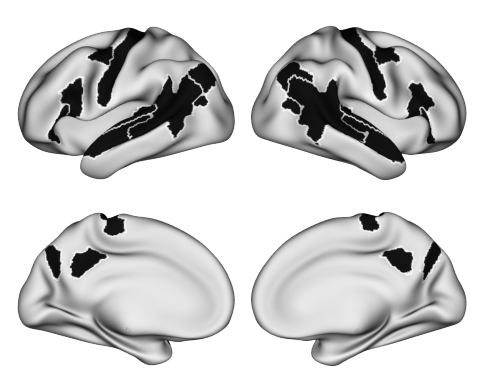

In [15]:
all_mask = (label_img > 0).astype(np.int32)
fig = plot.surface_plot(all_mask, atlas=custom_atlas, vmin=0, cmap='Greys', cbar=False, sulc_alpha=0.2, **fslr_params)
fig.savefig('figures/fig3-atlas-legend.svg')

In [ ]:
for label in custom_atlas.labels:
    mask = custom_atlas.roimask([label]).astype(np.int32)
    fig = plot.surface_plot(mask, vmin=0, vmax=1, cmap='Greys', cbar=False, sulc_alpha=0.2, **fslr_params)
    fig.suptitle(label)
    fig.show()

# misc

In [1]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
import torch
import matplotlib.pyplot as plt
 

In [5]:
model = AutoModelForCausalLM.from_pretrained('gpt2-xl')
# word_embeddings = model.transformer.wte.weight
position_embeddings = model.transformer.wpe.weight
position_embeddings.shape

torch.Size([1024, 1600])

In [15]:
embs = position_embeddings.numpy(force=True)
embs.shape

(1024, 1600)

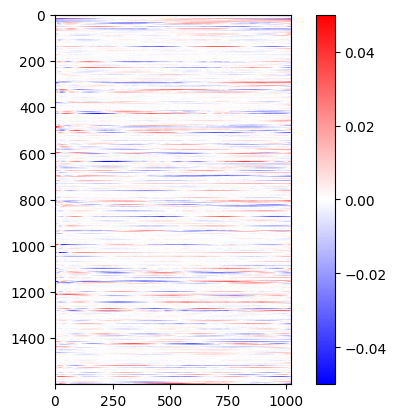

In [28]:
plt.imshow(embs.T, vmin=-.05, vmax=.05, cmap='bwr')
plt.colorbar()